Author: Carlos Roberto de Melo

Date: 12/12/2020

Obj: Rotate grid with pPXF data. The goal is align the x-axis with the major axis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from plotbin.sauron_colormap import register_sauron_colormap
from plotbin.plot_velfield import plot_velfield


from mpdaf.obj import Image

In [2]:
#Read pPXF maps with data

path = "/home/carlos/Documents/GitHub/Master-Degree/ESO325/Dynamical Modelling/Emcee-JAM/Data/"

Vrms_map = Image(path+"Velocity RMS Map Second Run.fits", ext=1)
erro_rms_map = Image(path+"Velocity RMS Map Second Run.fits", ext=2)




In [3]:
#Assuming the highest velocity in the center.

x = []   #x original position
y = []   #y original position

yc, xc = np.where(Vrms_map.data == Vrms_map[9,9]) #center position


vrms = [] #list for Vrms
erms = [] #list for error rms

In [4]:
#Buildind linear arrays

for i in range(Vrms_map.shape[0]):
    for j in range(Vrms_map.shape[1]):
        if not np.ma.core.is_masked(Vrms_map.data[i,j]):
            
            x.append(j)
            y.append(i)
            vrms.append(Vrms_map.data[i,j])
            erms.append(erro_rms_map[i,j])

In [5]:
#Transform list in arrays
x = np.array(x)
y = np.array(y)
vrms = np.array(vrms)
erms = np.array(erms)

Text(0.5, 1.0, 'Original')

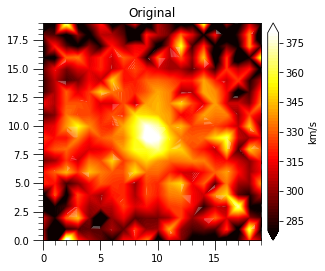

In [6]:
#Plot original data

plot_velfield(x, y, vrms,  colorbar=True, vmin=280, vmax=380, label='km/s', cmap=plt.cm.hot, nodots=True)

plt.title(r"Original")

In [7]:
#O JAM assume que a galáxia esteja com o seu semi-eixo maior sobre o eixo dos x, bem como o centro no ponto (0,0).
    #Por esse motivo vamos transladar as posições de modo que o centro seja o px com maior dispersão. E depois 
    #vamos rotacionar a galáxia para obter o semi-eixo maior sobre o eixo dos x. Como o find my galaxy retorna o
    #P.A (Position Angle) medido no sentido antihorário a partir do eixo y, precisamos rotacionar os nossos eixos
    #originais de 90°+P.A, para que o semi-eixo maior fique sobre o eixo x. No nosso caso, o P.A retornado é 67.7°

theta = 22.3 - 90        #ângulo de rotação em graus (find_my_galaxy PA: 22.3°)

#Transalação para que o centro seja o px (0,0)
x_new = x - xc
y_new = y - yc

#Rotação
x_rot = ( np.cos(theta*np.pi/180)*x_new + np.sin(theta*np.pi/180)*y_new )
y_rot = ( -np.sin(theta*np.pi/180)*x_new + np.cos(theta*np.pi/180)*y_new )

In [8]:
#Esse bloco não é necessário. Ele apenas verifica se a maior dispersão após a translação se encontra na posição (0,0)
#Além disso, olhamos também para ver se essa posição é mantida após a rotação
print("     x_px   y_px   disp \t   x_new   y_new   disp \t   x_rot   y_rot   disp")

for i in range(len(vrms)):
    print("%8.2f%8.2f%8.2f\t%8.2f%8.2f%8.2f\t%8.2f%8.2f%8.2f" % (x[i],y[i], vrms[i], x_new[i],y_new[i],vrms[i],x_rot[i],y_rot[i],vrms[i]))

     x_px   y_px   disp 	   x_new   y_new   disp 	   x_rot   y_rot   disp
    0.00    0.00  304.96	   -9.00   -9.00  304.96	    4.91  -11.74  304.96
    1.00    0.00  245.55	   -8.00   -9.00  245.55	    5.29  -10.82  245.55
    2.00    0.00  392.53	   -7.00   -9.00  392.53	    5.67   -9.89  392.53
    3.00    0.00  323.58	   -6.00   -9.00  323.58	    6.05   -8.97  323.58
    4.00    0.00  305.38	   -5.00   -9.00  305.38	    6.43   -8.04  305.38
    5.00    0.00  294.03	   -4.00   -9.00  294.03	    6.81   -7.12  294.03
    6.00    0.00  279.72	   -3.00   -9.00  279.72	    7.19   -6.19  279.72
    7.00    0.00  317.54	   -2.00   -9.00  317.54	    7.57   -5.27  317.54
    8.00    0.00  317.22	   -1.00   -9.00  317.22	    7.95   -4.34  317.22
    9.00    0.00  333.70	    0.00   -9.00  333.70	    8.33   -3.42  333.70
   10.00    0.00  256.13	    1.00   -9.00  256.13	    8.71   -2.49  256.13
   11.00    0.00  308.06	    2.00   -9.00  308.06	    9.09   -1.56  308.06
   12.00    0.00  297.41	 

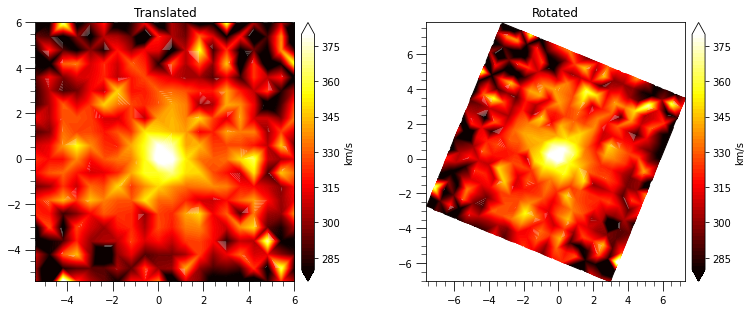

In [9]:
#Plotando o resultado da rotação e a imagem apenas transladada
plt.figure(figsize=(12,12))
plt.subplot(121)
plot_velfield(x_new*0.6, y_new*0.6, vrms,  vmin=280, vmax=380, colorbar=True, label='km/s', cmap=plt.cm.hot, nodots=True)
plt.title(r"Translated")

plt.subplot(122)
plot_velfield(x_rot*0.6, y_rot*0.6, vrms,  vmin=280, vmax=380, colorbar=True, label='km/s', cmap=plt.cm.hot, nodots=True)
plt.title(r"Rotated")


plt.tick_params(labelleft=True)
plt.subplots_adjust(wspace=0.4)

In [10]:
#Selecting pixels where we want to compute the model

x_good = []
y_good = []
vrms_good = []
erms_good = []

e = 0.24                                            #galaxy ellipticity. Value from find_my_galaxy 
pixsize = 0.6                                       #pixel size

for i in range(len(vrms)):
    r = np.sqrt((x_rot[i]*pixsize)**2 + ((y_rot[i])*pixsize/(1-e))**2)
    if r < 5:
        x_good.append(x_rot[i])
        y_good.append(y_rot[i])
        vrms_good.append(vrms[i])
        erms_good.append(erms[i])

In [11]:
#Transform in numpy array

x_good = np.array(x_good)
y_good = np.array(y_good)
vrms_good = np.array(vrms_good)
erms_good = np.array(erms_good)

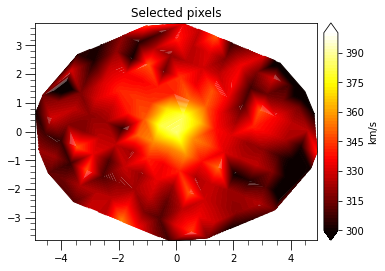

In [12]:
#Plot only the pixels seleted above

plot_velfield(x_good*0.6, y_good*0.6, vrms_good,  vmin=300, vmax=400, colorbar=True, label='km/s', cmap=plt.cm.hot, nodots=True)
plt.title(r"Selected pixels")


plt.tick_params(labelleft=True)
plt.subplots_adjust(wspace=0.4)

In [13]:
#Saving table with rotate data.

np.savetxt("pPXF_rot_data.txt", np.column_stack([y_good, x_good, vrms_good, erms_good]),
           fmt=b'\t%10.6f\t %10.6f\t %10.6f\t %10.6f\t ', 
           header="\t y_rot[px] \t x_rot[px] \t Vrms[kms⁻¹] \t Erms[kms⁻¹]",  delimiter='\t')